# Matrix Factorization with SimEc
In this notebook are some examples to show that SimEc can be used to compute the SVD or eigendecomposition of a matrix.

Performing an SVD and eigendecomposition of a matrix with neural networks was first described by A. Cichocki (et al.) in 1992 in [this paper (SVD)](http://ieeexplore.ieee.org/document/133134/?reload=true) and [this paper (eigendecomposition)](https://link.springer.com/article/10.1007/BF00201437).

In [1]:
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(28)
import keras

from simec import SimilarityEncoder

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
def msqe(A, B):
    # compute the mean squared error between two matrices A and B
    # obviously, A and B should be the same shape...
    return np.mean((A - B) ** 2)

In [3]:
# generate a random matrix
n_input = 500
n_output = 700
A = np.random.rand(n_input, n_output)
# compute its SVD
U, s, Vh = np.linalg.svd(A, full_matrices=True)
U.shape, s.shape, Vh.shape

((500, 500), (500,), (700, 700))

In [4]:
# make the eigenvalues of A a bit more extreme
S = np.zeros((n_input, n_output))
s[0] = s[1]+1
s[:10] *= 50.
s[10:20] *= 20.
s[20:100] *= 10.
S[:n_input, :n_input] = np.diag(s)
# recompute A and scale it to be in a somewhat reasonable range
A = np.dot(U, np.dot(S, Vh))
A = A/np.max(np.abs(A))
# recompute SVD again
U, s, Vh = np.linalg.svd(A, full_matrices=True)
S = np.zeros((n_input, n_output))
S[:n_input, :n_input] = np.diag(s)

In [5]:
# check that eigenvectors are orthogonal
np.dot(Vh[:100,:], Vh[:100,:].T)

array([[  1.00000000e+00,  -5.45570533e-16,   1.30971622e-16, ...,
          6.93889390e-17,   1.25767452e-17,  -1.38777878e-17],
       [ -5.45570533e-16,   1.00000000e+00,   2.48065457e-16, ...,
         -5.20417043e-17,  -9.19403442e-17,  -2.94902991e-17],
       [  1.30971622e-16,   2.48065457e-16,   1.00000000e+00, ...,
          3.46944695e-18,   7.97972799e-17,   8.58688121e-17],
       ..., 
       [  6.93889390e-17,  -5.20417043e-17,   3.46944695e-18, ...,
          1.00000000e+00,  -1.04083409e-15,   3.79904441e-16],
       [  1.25767452e-17,  -9.19403442e-17,   7.97972799e-17, ...,
         -1.04083409e-15,   1.00000000e+00,  -2.30067701e-16],
       [ -1.38777878e-17,  -2.94902991e-17,   8.58688121e-17, ...,
          3.79904441e-16,  -2.30067701e-16,   1.00000000e+00]])

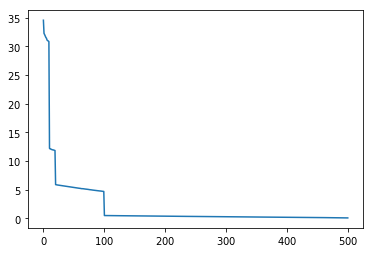

In [6]:
# inspect eigenvalues
plt.plot(s)

### SVD of a random matrix

In [7]:
# mean squared error of approximation decreases with more embedding dim
for e_dim in [2, 10, 25, 50, 75, 100, 250, 400, 500]:
    print "mse with %3i e_dim: %.8f" % (e_dim, msqe(A, np.dot(U[:,:e_dim], np.dot(S[:e_dim,:e_dim], Vh[:e_dim,:]))))

mse with   2 e_dim: 0.03285552
mse with  10 e_dim: 0.01045687
mse with  25 e_dim: 0.00588207
mse with  50 e_dim: 0.00367207
mse with  75 e_dim: 0.00175594
mse with 100 e_dim: 0.00009198
mse with 250 e_dim: 0.00002807
mse with 400 e_dim: 0.00000396
mse with 500 e_dim: 0.00000000


In [8]:
# factorize the matrix with a simec
X = np.eye(n_input)
mses = []
e_dims =  [2, 10, 25, 50, 75, 100, 250, 400, 500, 750, 1000]
l_rates = {400: 0.004, 500: 0.0034, 750: 0.0032, 1000: 0.003}
for e_dim in e_dims:
    model = SimilarityEncoder(n_input, e_dim, n_output, opt=keras.optimizers.Adamax(lr=0.005 if e_dim <= 250 else l_rates[e_dim]))
    model.fit(X, A, epochs=50)
    mse = msqe(A, model.predict(X))
    mses.append(mse)
    print "mse with %4i e_dim: %.8f" % (e_dim, mse)
for i, e_dim in enumerate(e_dims):
    print "mse with %4i e_dim: %.8f" % (e_dim, mses[i])

Epoch 1/50
500/500 [==============================] - 1s 1ms/step - loss: 0.0392
Epoch 2/50
500/500 [==============================] - 0s 84us/step - loss: 0.0388
Epoch 3/50
500/500 [==============================] - 0s 86us/step - loss: 0.0377
Epoch 4/50
500/500 [==============================] - 0s 84us/step - loss: 0.0365
Epoch 5/50
500/500 [==============================] - 0s 82us/step - loss: 0.0360
Epoch 6/50
500/500 [==============================] - 0s 107us/step - loss: 0.0359
Epoch 7/50
500/500 [==============================] - 0s 94us/step - loss: 0.0359
Epoch 8/50
500/500 [==============================] - 0s 97us/step - loss: 0.0358
Epoch 9/50
500/500 [==============================] - 0s 83us/step - loss: 0.0358
Epoch 10/50
500/500 [==============================] - 0s 85us/step - loss: 0.0358
Epoch 11/50
500/500 [==============================] - 0s 91us/step - loss: 0.0358
Epoch 12/50
500/500 [==============================] - 0s 90us/step - loss: 0.0357
Epoch 13/50
5

500/500 [==============================] - 0s 82us/step - loss: 0.0118
Epoch 50/50
500/500 [==============================] - 0s 75us/step - loss: 0.0117
mse with   10 e_dim: 0.01103407
Epoch 1/50
500/500 [==============================] - 0s 227us/step - loss: 0.0392
Epoch 2/50
500/500 [==============================] - 0s 73us/step - loss: 0.0366
Epoch 3/50
500/500 [==============================] - 0s 88us/step - loss: 0.0358
Epoch 4/50
500/500 [==============================] - 0s 68us/step - loss: 0.0354
Epoch 5/50
500/500 [==============================] - 0s 65us/step - loss: 0.0350
Epoch 6/50
500/500 [==============================] - 0s 82us/step - loss: 0.0344
Epoch 7/50
500/500 [==============================] - 0s 93us/step - loss: 0.0337
Epoch 8/50
500/500 [==============================] - 0s 103us/step - loss: 0.0327
Epoch 9/50
500/500 [==============================] - 0s 75us/step - loss: 0.0316
Epoch 10/50
500/500 [==============================] - 0s 82us/step - loss

500/500 [==============================] - 0s 79us/step - loss: 0.0061
Epoch 48/50
500/500 [==============================] - 0s 74us/step - loss: 0.0060
Epoch 49/50
500/500 [==============================] - 0s 97us/step - loss: 0.0059
Epoch 50/50
500/500 [==============================] - 0s 88us/step - loss: 0.0059
mse with   50 e_dim: 0.00471323
Epoch 1/50
500/500 [==============================] - 0s 292us/step - loss: 0.0395
Epoch 2/50
500/500 [==============================] - 0s 108us/step - loss: 0.0361
Epoch 3/50
500/500 [==============================] - 0s 69us/step - loss: 0.0353
Epoch 4/50
500/500 [==============================] - 0s 78us/step - loss: 0.0341
Epoch 5/50
500/500 [==============================] - 0s 80us/step - loss: 0.0326
Epoch 6/50
500/500 [==============================] - 0s 70us/step - loss: 0.0305
Epoch 7/50
500/500 [==============================] - 0s 94us/step - loss: 0.0280
Epoch 8/50
500/500 [==============================] - 0s 81us/step - los

Epoch 45/50
500/500 [==============================] - 0s 82us/step - loss: 0.0034
Epoch 46/50
500/500 [==============================] - 0s 83us/step - loss: 0.0033
Epoch 47/50
500/500 [==============================] - 0s 92us/step - loss: 0.0032
Epoch 48/50
500/500 [==============================] - 0s 100us/step - loss: 0.0031
Epoch 49/50
500/500 [==============================] - 0s 78us/step - loss: 0.0030
Epoch 50/50
500/500 [==============================] - 0s 80us/step - loss: 0.0029
mse with  100 e_dim: 0.00132271
Epoch 1/50
500/500 [==============================] - 0s 343us/step - loss: 0.0401
Epoch 2/50
500/500 [==============================] - 0s 91us/step - loss: 0.0356
Epoch 3/50
500/500 [==============================] - 0s 99us/step - loss: 0.0329
Epoch 4/50
500/500 [==============================] - 0s 104us/step - loss: 0.0291
Epoch 5/50
500/500 [==============================] - 0s 82us/step - loss: 0.0242
Epoch 6/50
500/500 [==============================] - 0s 

500/500 [==============================] - 0s 86us/step - loss: 0.0019
Epoch 44/50
500/500 [==============================] - 0s 92us/step - loss: 0.0019
Epoch 45/50
500/500 [==============================] - 0s 83us/step - loss: 0.0019
Epoch 46/50
500/500 [==============================] - 0s 97us/step - loss: 0.0018
Epoch 47/50
500/500 [==============================] - 0s 98us/step - loss: 0.0018
Epoch 48/50
500/500 [==============================] - 0s 92us/step - loss: 0.0018
Epoch 49/50
500/500 [==============================] - 0s 96us/step - loss: 0.0017
Epoch 50/50
500/500 [==============================] - 0s 102us/step - loss: 0.0017
mse with  400 e_dim: 0.00018774
Epoch 1/50
500/500 [==============================] - 0s 400us/step - loss: 0.0418
Epoch 2/50
500/500 [==============================] - 0s 84us/step - loss: 0.0362
Epoch 3/50
500/500 [==============================] - 0s 91us/step - loss: 0.0333
Epoch 4/50
500/500 [==============================] - 0s 84us/step -

500/500 [==============================] - 0s 97us/step - loss: 0.0021
Epoch 41/50
500/500 [==============================] - 0s 96us/step - loss: 0.0020
Epoch 42/50
500/500 [==============================] - 0s 110us/step - loss: 0.0020
Epoch 43/50
500/500 [==============================] - 0s 99us/step - loss: 0.0020
Epoch 44/50
500/500 [==============================] - 0s 106us/step - loss: 0.0019
Epoch 45/50
500/500 [==============================] - 0s 114us/step - loss: 0.0019
Epoch 46/50
500/500 [==============================] - 0s 106us/step - loss: 0.0019
Epoch 47/50
500/500 [==============================] - 0s 120us/step - loss: 0.0018
Epoch 48/50
500/500 [==============================] - 0s 99us/step - loss: 0.0018
Epoch 49/50
500/500 [==============================] - 0s 109us/step - loss: 0.0018
Epoch 50/50
500/500 [==============================] - 0s 105us/step - loss: 0.0018
mse with  750 e_dim: 0.00016951
Epoch 1/50
500/500 [==============================] - 0s 493

In [9]:
# factorize the matrix with a simec - transpose works just as well
# this time we use the embedding we learned before as the weights of the last layer
# to get the mapping function for the other side of the equation (which is of course kind of useless
# here since we don't actually map feature vectors but only identiy vectors)
X1 = np.eye(n_input)
X2 = np.eye(n_output)
mses1 = []
mses2 = []
mses3 = []
e_dims =  [2, 10, 25, 50, 75, 100, 250, 400, 500, 750, 1000]
for e_dim in e_dims:
    model = SimilarityEncoder(n_input, e_dim, n_output, opt=keras.optimizers.Adamax(lr=0.005 if e_dim <= 250 else l_rates[e_dim]))
    model.fit(X1, A, epochs=50)
    mse = msqe(A, model.predict(X1))
    mses1.append(mse)
    print "mse with %4i e_dim: %.8f" % (e_dim, mse)
    Y1 = model.transform(X1)
    model = SimilarityEncoder(n_output, e_dim, n_input, W_ll=Y1.T, opt=keras.optimizers.Adamax(lr=0.005 if e_dim <= 250 else l_rates[e_dim]))
    model.fit(X2, A.T, epochs=50)
    mse = msqe(A.T, model.predict(X2))
    mses2.append(mse)
    print "mse with %4i e_dim: %.8f" % (e_dim, mse)
    Y2 = model.transform(X2)
    # the dot product of both embeddings should also approximate A
    mse = msqe(A, np.dot(Y1, Y2.T))
    mses3.append(mse)
for i, e_dim in enumerate(e_dims):
    print "mse with %4i e_dim: %.8f / %.8f / %.8f" % (e_dim, mses1[i], mses2[i], mses3[i])

Epoch 1/50
500/500 [==============================] - 0s 426us/step - loss: 0.0392
Epoch 2/50
500/500 [==============================] - 0s 89us/step - loss: 0.0388
Epoch 3/50
500/500 [==============================] - 0s 90us/step - loss: 0.0378
Epoch 4/50
500/500 [==============================] - 0s 87us/step - loss: 0.0366
Epoch 5/50
500/500 [==============================] - 0s 104us/step - loss: 0.0360
Epoch 6/50
500/500 [==============================] - 0s 81us/step - loss: 0.0359
Epoch 7/50
500/500 [==============================] - 0s 88us/step - loss: 0.0359
Epoch 8/50
500/500 [==============================] - 0s 73us/step - loss: 0.0358
Epoch 9/50
500/500 [==============================] - 0s 76us/step - loss: 0.0358
Epoch 10/50
500/500 [==============================] - 0s 79us/step - loss: 0.0358
Epoch 11/50
500/500 [==============================] - 0s 68us/step - loss: 0.0358
Epoch 12/50
500/500 [==============================] - 0s 77us/step - loss: 0.0358
Epoch 13/50

700/700 [==============================] - 0s 71us/step - loss: 0.0341
Epoch 50/50
700/700 [==============================] - 0s 77us/step - loss: 0.0341
mse with    2 e_dim: 0.03387377
Epoch 1/50
500/500 [==============================] - 0s 441us/step - loss: 0.0392
Epoch 2/50
500/500 [==============================] - 0s 70us/step - loss: 0.0377
Epoch 3/50
500/500 [==============================] - 0s 77us/step - loss: 0.0361
Epoch 4/50
500/500 [==============================] - 0s 71us/step - loss: 0.0358
Epoch 5/50
500/500 [==============================] - 0s 94us/step - loss: 0.0357
Epoch 6/50
500/500 [==============================] - 0s 83us/step - loss: 0.0355
Epoch 7/50
500/500 [==============================] - 0s 84us/step - loss: 0.0354
Epoch 8/50
500/500 [==============================] - 0s 81us/step - loss: 0.0351
Epoch 9/50
500/500 [==============================] - 0s 86us/step - loss: 0.0348
Epoch 10/50
500/500 [==============================] - 0s 76us/step - loss:

700/700 [==============================] - 0s 65us/step - loss: 0.0245
Epoch 48/50
700/700 [==============================] - 0s 74us/step - loss: 0.0244
Epoch 49/50
700/700 [==============================] - 0s 97us/step - loss: 0.0242
Epoch 50/50
700/700 [==============================] - 0s 94us/step - loss: 0.0241
mse with   10 e_dim: 0.02232746
Epoch 1/50
500/500 [==============================] - 0s 494us/step - loss: 0.0394
Epoch 2/50
500/500 [==============================] - 0s 91us/step - loss: 0.0368
Epoch 3/50
500/500 [==============================] - 0s 88us/step - loss: 0.0358
Epoch 4/50
500/500 [==============================] - 0s 86us/step - loss: 0.0355
Epoch 5/50
500/500 [==============================] - 0s 106us/step - loss: 0.0351
Epoch 6/50
500/500 [==============================] - 0s 82us/step - loss: 0.0345
Epoch 7/50
500/500 [==============================] - 0s 81us/step - loss: 0.0338
Epoch 8/50
500/500 [==============================] - 0s 93us/step - los

700/700 [==============================] - 0s 77us/step - loss: 0.0214
Epoch 46/50
700/700 [==============================] - 0s 77us/step - loss: 0.0213
Epoch 47/50
700/700 [==============================] - 0s 77us/step - loss: 0.0211
Epoch 48/50
700/700 [==============================] - 0s 89us/step - loss: 0.0210
Epoch 49/50
700/700 [==============================] - 0s 85us/step - loss: 0.0209
Epoch 50/50
700/700 [==============================] - 0s 87us/step - loss: 0.0208
mse with   25 e_dim: 0.01743545
Epoch 1/50
500/500 [==============================] - 0s 570us/step - loss: 0.0395
Epoch 2/50
500/500 [==============================] - 0s 76us/step - loss: 0.0364
Epoch 3/50
500/500 [==============================] - 0s 69us/step - loss: 0.0356
Epoch 4/50
500/500 [==============================] - 0s 76us/step - loss: 0.0349
Epoch 5/50
500/500 [==============================] - 0s 74us/step - loss: 0.0339
Epoch 6/50
500/500 [==============================] - 0s 75us/step - lo

700/700 [==============================] - 0s 77us/step - loss: 0.0200
Epoch 44/50
700/700 [==============================] - 0s 93us/step - loss: 0.0199
Epoch 45/50
700/700 [==============================] - 0s 73us/step - loss: 0.0198
Epoch 46/50
700/700 [==============================] - 0s 69us/step - loss: 0.0197
Epoch 47/50
700/700 [==============================] - 0s 97us/step - loss: 0.0196
Epoch 48/50
700/700 [==============================] - 0s 94us/step - loss: 0.0195
Epoch 49/50
700/700 [==============================] - 0s 74us/step - loss: 0.0194
Epoch 50/50
700/700 [==============================] - 0s 82us/step - loss: 0.0193
mse with   50 e_dim: 0.01449150
Epoch 1/50
500/500 [==============================] - 0s 628us/step - loss: 0.0396
Epoch 2/50
500/500 [==============================] - 0s 79us/step - loss: 0.0362
Epoch 3/50
500/500 [==============================] - 0s 86us/step - loss: 0.0353
Epoch 4/50
500/500 [==============================] - 0s 89us/step - 

700/700 [==============================] - 0s 90us/step - loss: 0.0195
Epoch 41/50
700/700 [==============================] - 0s 84us/step - loss: 0.0194
Epoch 42/50
700/700 [==============================] - 0s 73us/step - loss: 0.0193
Epoch 43/50
700/700 [==============================] - 0s 85us/step - loss: 0.0192
Epoch 44/50
700/700 [==============================] - 0s 87us/step - loss: 0.0191
Epoch 45/50
700/700 [==============================] - 0s 93us/step - loss: 0.0190
Epoch 46/50
700/700 [==============================] - 0s 85us/step - loss: 0.0190
Epoch 47/50
700/700 [==============================] - 0s 94us/step - loss: 0.0189
Epoch 48/50
700/700 [==============================] - 0s 94us/step - loss: 0.0188
Epoch 49/50
700/700 [==============================] - 0s 90us/step - loss: 0.0188
Epoch 50/50
700/700 [==============================] - 0s 91us/step - loss: 0.0187
mse with   75 e_dim: 0.01294556
Epoch 1/50
500/500 [==============================] - 0s 636us/step

700/700 [==============================] - 0s 85us/step - loss: 0.0191
Epoch 39/50
700/700 [==============================] - 0s 125us/step - loss: 0.0190
Epoch 40/50
700/700 [==============================] - 0s 98us/step - loss: 0.0189
Epoch 41/50
700/700 [==============================] - 0s 83us/step - loss: 0.0189
Epoch 42/50
700/700 [==============================] - 0s 75us/step - loss: 0.0188
Epoch 43/50
700/700 [==============================] - 0s 74us/step - loss: 0.0187
Epoch 44/50
700/700 [==============================] - 0s 85us/step - loss: 0.0187
Epoch 45/50
700/700 [==============================] - 0s 88us/step - loss: 0.0186
Epoch 46/50
700/700 [==============================] - 0s 86us/step - loss: 0.0185
Epoch 47/50
700/700 [==============================] - 0s 75us/step - loss: 0.0185
Epoch 48/50
700/700 [==============================] - 0s 87us/step - loss: 0.0184
Epoch 49/50
700/700 [==============================] - 0s 83us/step - loss: 0.0184
Epoch 50/50
700

700/700 [==============================] - 0s 71us/step - loss: 0.0189
Epoch 36/50
700/700 [==============================] - 0s 75us/step - loss: 0.0188
Epoch 37/50
700/700 [==============================] - 0s 75us/step - loss: 0.0188
Epoch 38/50
700/700 [==============================] - 0s 103us/step - loss: 0.0188
Epoch 39/50
700/700 [==============================] - 0s 74us/step - loss: 0.0187
Epoch 40/50
700/700 [==============================] - 0s 94us/step - loss: 0.0187
Epoch 41/50
700/700 [==============================] - 0s 73us/step - loss: 0.0186
Epoch 42/50
700/700 [==============================] - 0s 75us/step - loss: 0.0186
Epoch 43/50
700/700 [==============================] - 0s 73us/step - loss: 0.0186
Epoch 44/50
700/700 [==============================] - 0s 79us/step - loss: 0.0186
Epoch 45/50
700/700 [==============================] - 0s 85us/step - loss: 0.0185
Epoch 46/50
700/700 [==============================] - 0s 89us/step - loss: 0.0185
Epoch 47/50
700

700/700 [==============================] - 0s 75us/step - loss: 0.0186
Epoch 34/50
700/700 [==============================] - 0s 85us/step - loss: 0.0185
Epoch 35/50
700/700 [==============================] - 0s 94us/step - loss: 0.0185
Epoch 36/50
700/700 [==============================] - 0s 94us/step - loss: 0.0184
Epoch 37/50
700/700 [==============================] - 0s 82us/step - loss: 0.0184
Epoch 38/50
700/700 [==============================] - 0s 91us/step - loss: 0.0183
Epoch 39/50
700/700 [==============================] - 0s 75us/step - loss: 0.0183
Epoch 40/50
700/700 [==============================] - 0s 72us/step - loss: 0.0182
Epoch 41/50
700/700 [==============================] - 0s 90us/step - loss: 0.0182
Epoch 42/50
700/700 [==============================] - 0s 92us/step - loss: 0.0182
Epoch 43/50
700/700 [==============================] - 0s 90us/step - loss: 0.0181
Epoch 44/50
700/700 [==============================] - 0s 98us/step - loss: 0.0181
Epoch 45/50
700/

Epoch 31/50
700/700 [==============================] - 0s 85us/step - loss: 0.0185
Epoch 32/50
700/700 [==============================] - 0s 89us/step - loss: 0.0184
Epoch 33/50
700/700 [==============================] - 0s 85us/step - loss: 0.0183
Epoch 34/50
700/700 [==============================] - 0s 94us/step - loss: 0.0183
Epoch 35/50
700/700 [==============================] - 0s 97us/step - loss: 0.0182
Epoch 36/50
700/700 [==============================] - 0s 84us/step - loss: 0.0181
Epoch 37/50
700/700 [==============================] - 0s 88us/step - loss: 0.0181
Epoch 38/50
700/700 [==============================] - 0s 99us/step - loss: 0.0180
Epoch 39/50
700/700 [==============================] - ETA: 0s - loss: 0.018 - 0s 94us/step - loss: 0.0179
Epoch 40/50
700/700 [==============================] - 0s 98us/step - loss: 0.0179
Epoch 41/50
700/700 [==============================] - 0s 96us/step - loss: 0.0179
Epoch 42/50
700/700 [==============================] - 0s 84us/

700/700 [==============================] - 0s 90us/step - loss: 0.0190
Epoch 28/50
700/700 [==============================] - 0s 88us/step - loss: 0.0189
Epoch 29/50
700/700 [==============================] - 0s 91us/step - loss: 0.0187
Epoch 30/50
700/700 [==============================] - 0s 93us/step - loss: 0.0186
Epoch 31/50
700/700 [==============================] - 0s 85us/step - loss: 0.0185
Epoch 32/50
700/700 [==============================] - 0s 106us/step - loss: 0.0185
Epoch 33/50
700/700 [==============================] - 0s 83us/step - loss: 0.0184
Epoch 34/50
700/700 [==============================] - 0s 85us/step - loss: 0.0183
Epoch 35/50
700/700 [==============================] - 0s 104us/step - loss: 0.0183
Epoch 36/50
700/700 [==============================] - 0s 107us/step - loss: 0.0182
Epoch 37/50
700/700 [==============================] - 0s 79us/step - loss: 0.0182
Epoch 38/50
700/700 [==============================] - 0s 79us/step - loss: 0.0181
Epoch 39/50
7

700/700 [==============================] - 0s 110us/step - loss: 0.0194
Epoch 25/50
700/700 [==============================] - 0s 108us/step - loss: 0.0193
Epoch 26/50
700/700 [==============================] - 0s 118us/step - loss: 0.0191
Epoch 27/50
700/700 [==============================] - 0s 110us/step - loss: 0.0190
Epoch 28/50
700/700 [==============================] - 0s 108us/step - loss: 0.0189
Epoch 29/50
700/700 [==============================] - 0s 124us/step - loss: 0.0188
Epoch 30/50
700/700 [==============================] - 0s 112us/step - loss: 0.0187
Epoch 31/50
700/700 [==============================] - 0s 121us/step - loss: 0.0186
Epoch 32/50
700/700 [==============================] - 0s 106us/step - loss: 0.0185
Epoch 33/50
700/700 [==============================] - 0s 106us/step - loss: 0.0185
Epoch 34/50
700/700 [==============================] - 0s 107us/step - loss: 0.0184
Epoch 35/50
700/700 [==============================] - 0s 111us/step - loss: 0.0184
Epoc

#### Dealing with missing values
A regular SVD can not be computed for a matrix with missing values, therefore these need to be filled by some values, e.g. the average of the matrix. SimEc on the other hand can compute the backpropagation error considering only the available entries of the matrix, which means it can easily handle about 50% missing values without seeing major performance decreases and consistently outperforms the regular SVD (results would probably be even better with more careful hyperparameter tuning, e.g. using some regularization).

0.0
Epoch 1/60
500/500 [==============================] - 0s 944us/step - loss: 0.0379
Epoch 2/60
500/500 [==============================] - 0s 97us/step - loss: 0.0361
Epoch 3/60
500/500 [==============================] - 0s 78us/step - loss: 0.0360
Epoch 4/60
500/500 [==============================] - 0s 89us/step - loss: 0.0358
Epoch 5/60
500/500 [==============================] - 0s 96us/step - loss: 0.0357
Epoch 6/60
500/500 [==============================] - 0s 88us/step - loss: 0.0355
Epoch 7/60
500/500 [==============================] - 0s 93us/step - loss: 0.0350
Epoch 8/60
500/500 [==============================] - 0s 84us/step - loss: 0.0345
Epoch 9/60
500/500 [==============================] - 0s 89us/step - loss: 0.0339
Epoch 10/60
500/500 [==============================] - 0s 95us/step - loss: 0.0336
Epoch 11/60
500/500 [==============================] - 0s 88us/step - loss: 0.0334
Epoch 12/60
500/500 [==============================] - 0s 88us/step - loss: 0.0333
Epoch 13

500/500 [==============================] - 0s 73us/step - loss: 0.0331
Epoch 40/60
500/500 [==============================] - 0s 74us/step - loss: 0.0331
Epoch 41/60
500/500 [==============================] - 0s 78us/step - loss: 0.0331
Epoch 42/60
500/500 [==============================] - 0s 85us/step - loss: 0.0331
Epoch 43/60
500/500 [==============================] - 0s 107us/step - loss: 0.0331
Epoch 44/60
500/500 [==============================] - 0s 84us/step - loss: 0.0331
Epoch 45/60
500/500 [==============================] - 0s 88us/step - loss: 0.0331
Epoch 46/60
500/500 [==============================] - 0s 86us/step - loss: 0.0331
Epoch 47/60
500/500 [==============================] - 0s 85us/step - loss: 0.0331
Epoch 48/60
500/500 [==============================] - 0s 101us/step - loss: 0.0331
Epoch 49/60
500/500 [==============================] - 0s 111us/step - loss: 0.0331
Epoch 50/60
500/500 [==============================] - 0s 95us/step - loss: 0.0331
Epoch 51/60
5

500/500 [==============================] - 0s 94us/step - loss: 0.0329
Epoch 18/60
500/500 [==============================] - 0s 74us/step - loss: 0.0329
Epoch 19/60
500/500 [==============================] - 0s 82us/step - loss: 0.0329
Epoch 20/60
500/500 [==============================] - 0s 80us/step - loss: 0.0329
Epoch 21/60
500/500 [==============================] - 0s 91us/step - loss: 0.0329
Epoch 22/60
500/500 [==============================] - 0s 88us/step - loss: 0.0329
Epoch 23/60
500/500 [==============================] - 0s 94us/step - loss: 0.0329
Epoch 24/60
500/500 [==============================] - 0s 83us/step - loss: 0.0329
Epoch 25/60
500/500 [==============================] - 0s 79us/step - loss: 0.0328
Epoch 26/60
500/500 [==============================] - 0s 74us/step - loss: 0.0328
Epoch 27/60
500/500 [==============================] - 0s 87us/step - loss: 0.0328
Epoch 28/60
500/500 [==============================] - 0s 93us/step - loss: 0.0328
Epoch 29/60
500/

500/500 [==============================] - 0s 80us/step - loss: 0.0328
Epoch 56/60
500/500 [==============================] - 0s 85us/step - loss: 0.0328
Epoch 57/60
500/500 [==============================] - 0s 78us/step - loss: 0.0328
Epoch 58/60
500/500 [==============================] - 0s 94us/step - loss: 0.0328
Epoch 59/60
500/500 [==============================] - 0s 104us/step - loss: 0.0328
Epoch 60/60
500/500 [==============================] - 0s 92us/step - loss: 0.0328
0.5
Epoch 1/60
500/500 [==============================] - 1s 1ms/step - loss: 0.0391
Epoch 2/60
500/500 [==============================] - 0s 106us/step - loss: 0.0365
Epoch 3/60
500/500 [==============================] - 0s 87us/step - loss: 0.0359
Epoch 4/60
500/500 [==============================] - 0s 92us/step - loss: 0.0358
Epoch 5/60
500/500 [==============================] - 0s 94us/step - loss: 0.0355
Epoch 6/60
500/500 [==============================] - 0s 104us/step - loss: 0.0352
Epoch 7/60
500/5

500/500 [==============================] - 0s 82us/step - loss: 0.0329
Epoch 34/60
500/500 [==============================] - 0s 82us/step - loss: 0.0329
Epoch 35/60
500/500 [==============================] - 0s 85us/step - loss: 0.0329
Epoch 36/60
500/500 [==============================] - 0s 75us/step - loss: 0.0329
Epoch 37/60
500/500 [==============================] - 0s 98us/step - loss: 0.0329
Epoch 38/60
500/500 [==============================] - 0s 96us/step - loss: 0.0329
Epoch 39/60
500/500 [==============================] - 0s 98us/step - loss: 0.0329
Epoch 40/60
500/500 [==============================] - 0s 86us/step - loss: 0.0329
Epoch 41/60
500/500 [==============================] - 0s 86us/step - loss: 0.0329
Epoch 42/60
500/500 [==============================] - 0s 86us/step - loss: 0.0329
Epoch 43/60
500/500 [==============================] - 0s 85us/step - loss: 0.0329
Epoch 44/60
500/500 [==============================] - 0s 113us/step - loss: 0.0329
Epoch 45/60
500

500/500 [==============================] - 0s 96us/step - loss: 0.0346
Epoch 12/60
500/500 [==============================] - 0s 85us/step - loss: 0.0343
Epoch 13/60
500/500 [==============================] - 0s 87us/step - loss: 0.0340
Epoch 14/60
500/500 [==============================] - 0s 90us/step - loss: 0.0338
Epoch 15/60
500/500 [==============================] - 0s 102us/step - loss: 0.0335
Epoch 16/60
500/500 [==============================] - 0s 93us/step - loss: 0.0334
Epoch 17/60
500/500 [==============================] - 0s 87us/step - loss: 0.0332
Epoch 18/60
500/500 [==============================] - 0s 86us/step - loss: 0.0331
Epoch 19/60
500/500 [==============================] - 0s 92us/step - loss: 0.0330
Epoch 20/60
500/500 [==============================] - 0s 90us/step - loss: 0.0330
Epoch 21/60
500/500 [==============================] - 0s 93us/step - loss: 0.0329
Epoch 22/60
500/500 [==============================] - 0s 89us/step - loss: 0.0329
Epoch 23/60
500

500/500 [==============================] - 0s 88us/step - loss: 0.0319
Epoch 50/60
500/500 [==============================] - 0s 103us/step - loss: 0.0318
Epoch 51/60
500/500 [==============================] - 0s 105us/step - loss: 0.0318
Epoch 52/60
500/500 [==============================] - 0s 104us/step - loss: 0.0318
Epoch 53/60
500/500 [==============================] - 0s 97us/step - loss: 0.0318
Epoch 54/60
500/500 [==============================] - 0s 95us/step - loss: 0.0318
Epoch 55/60
500/500 [==============================] - 0s 95us/step - loss: 0.0318
Epoch 56/60
500/500 [==============================] - 0s 91us/step - loss: 0.0318
Epoch 57/60
500/500 [==============================] - 0s 92us/step - loss: 0.0318
Epoch 58/60
500/500 [==============================] - 0s 101us/step - loss: 0.0318
Epoch 59/60
500/500 [==============================] - 0s 92us/step - loss: 0.0318
Epoch 60/60
500/500 [==============================] - 0s 121us/step - loss: 0.0318
[0.03301345

500/500 [==============================] - 0s 79us/step - loss: 0.0110
Epoch 25/60
500/500 [==============================] - 0s 99us/step - loss: 0.0110
Epoch 26/60
500/500 [==============================] - 0s 91us/step - loss: 0.0110
Epoch 27/60
500/500 [==============================] - 0s 90us/step - loss: 0.0110
Epoch 28/60
500/500 [==============================] - 0s 105us/step - loss: 0.0110
Epoch 29/60
500/500 [==============================] - 0s 82us/step - loss: 0.0110
Epoch 30/60
500/500 [==============================] - 0s 107us/step - loss: 0.0110
Epoch 31/60
500/500 [==============================] - 0s 101us/step - loss: 0.0110
Epoch 32/60
500/500 [==============================] - 0s 114us/step - loss: 0.0110
Epoch 33/60
500/500 [==============================] - 0s 75us/step - loss: 0.0110
Epoch 34/60
500/500 [==============================] - 0s 76us/step - loss: 0.0110
Epoch 35/60
500/500 [==============================] - 0s 105us/step - loss: 0.0110
Epoch 36/60

500/500 [==============================] - 0s 85us/step - loss: 0.0355
Epoch 3/60
500/500 [==============================] - 0s 93us/step - loss: 0.0337
Epoch 4/60
500/500 [==============================] - 0s 87us/step - loss: 0.0307
Epoch 5/60
500/500 [==============================] - 0s 97us/step - loss: 0.0270
Epoch 6/60
500/500 [==============================] - 0s 95us/step - loss: 0.0232
Epoch 7/60
500/500 [==============================] - 0s 84us/step - loss: 0.0198
Epoch 8/60
500/500 [==============================] - 0s 95us/step - loss: 0.0172
Epoch 9/60
500/500 [==============================] - 0s 90us/step - loss: 0.0154
Epoch 10/60
500/500 [==============================] - 0s 97us/step - loss: 0.0144
Epoch 11/60
500/500 [==============================] - 0s 91us/step - loss: 0.0139
Epoch 12/60
500/500 [==============================] - 0s 87us/step - loss: 0.0135
Epoch 13/60
500/500 [==============================] - 0s 104us/step - loss: 0.0130
Epoch 14/60
500/500 [=

500/500 [==============================] - 0s 97us/step - loss: 0.0108
Epoch 41/60
500/500 [==============================] - 0s 81us/step - loss: 0.0108
Epoch 42/60
500/500 [==============================] - 0s 101us/step - loss: 0.0108
Epoch 43/60
500/500 [==============================] - 0s 96us/step - loss: 0.0108
Epoch 44/60
500/500 [==============================] - 0s 97us/step - loss: 0.0108
Epoch 45/60
500/500 [==============================] - 0s 89us/step - loss: 0.0108
Epoch 46/60
500/500 [==============================] - 0s 86us/step - loss: 0.0108
Epoch 47/60
500/500 [==============================] - 0s 90us/step - loss: 0.0107
Epoch 48/60
500/500 [==============================] - 0s 96us/step - loss: 0.0108
Epoch 49/60
500/500 [==============================] - 0s 94us/step - loss: 0.0108
Epoch 50/60
500/500 [==============================] - 0s 88us/step - loss: 0.0108
Epoch 51/60
500/500 [==============================] - 0s 93us/step - loss: 0.0108
Epoch 52/60
500

500/500 [==============================] - 0s 79us/step - loss: 0.0108
Epoch 19/60
500/500 [==============================] - 0s 82us/step - loss: 0.0107
Epoch 20/60
500/500 [==============================] - 0s 91us/step - loss: 0.0107
Epoch 21/60
500/500 [==============================] - 0s 106us/step - loss: 0.0107
Epoch 22/60
500/500 [==============================] - 0s 84us/step - loss: 0.0107
Epoch 23/60
500/500 [==============================] - 0s 83us/step - loss: 0.0107
Epoch 24/60
500/500 [==============================] - 0s 106us/step - loss: 0.0107
Epoch 25/60
500/500 [==============================] - 0s 105us/step - loss: 0.0106
Epoch 26/60
500/500 [==============================] - 0s 92us/step - loss: 0.0106
Epoch 27/60
500/500 [==============================] - 0s 92us/step - loss: 0.0106
Epoch 28/60
500/500 [==============================] - 0s 90us/step - loss: 0.0106
Epoch 29/60
500/500 [==============================] - 0s 88us/step - loss: 0.0106
Epoch 30/60
5

500/500 [==============================] - 0s 92us/step - loss: 0.0155
Epoch 57/60
500/500 [==============================] - 0s 100us/step - loss: 0.0155
Epoch 58/60
500/500 [==============================] - 0s 94us/step - loss: 0.0155
Epoch 59/60
500/500 [==============================] - 0s 96us/step - loss: 0.0155
Epoch 60/60
500/500 [==============================] - 0s 81us/step - loss: 0.0155
0.8
Epoch 1/60
500/500 [==============================] - 1s 1ms/step - loss: 0.0380
Epoch 2/60
500/500 [==============================] - 0s 90us/step - loss: 0.0359
Epoch 3/60
500/500 [==============================] - 0s 100us/step - loss: 0.0352
Epoch 4/60
500/500 [==============================] - 0s 108us/step - loss: 0.0343
Epoch 5/60
500/500 [==============================] - 0s 98us/step - loss: 0.0329
Epoch 6/60
500/500 [==============================] - 0s 107us/step - loss: 0.0311
Epoch 7/60
500/500 [==============================] - ETA: 0s - loss: 0.032 - 0s 79us/step - loss:

500/500 [==============================] - 0s 93us/step - loss: 0.0150
Epoch 35/60
500/500 [==============================] - 0s 109us/step - loss: 0.0150
Epoch 36/60
500/500 [==============================] - 0s 101us/step - loss: 0.0149
Epoch 37/60
500/500 [==============================] - 0s 101us/step - loss: 0.0149
Epoch 38/60
500/500 [==============================] - 0s 103us/step - loss: 0.0148
Epoch 39/60
500/500 [==============================] - 0s 84us/step - loss: 0.0148
Epoch 40/60
500/500 [==============================] - 0s 127us/step - loss: 0.0148
Epoch 41/60
500/500 [==============================] - 0s 116us/step - loss: 0.0147
Epoch 42/60
500/500 [==============================] - 0s 101us/step - loss: 0.0147
Epoch 43/60
500/500 [==============================] - 0s 99us/step - loss: 0.0147
Epoch 44/60
500/500 [==============================] - 0s 111us/step - loss: 0.0147
Epoch 45/60
500/500 [==============================] - 0s 105us/step - loss: 0.0146
Epoch 4

500/500 [==============================] - 0s 90us/step - loss: 0.0109
Epoch 11/60
500/500 [==============================] - 0s 111us/step - loss: 0.0103
Epoch 12/60
500/500 [==============================] - 0s 98us/step - loss: 0.0098
Epoch 13/60
500/500 [==============================] - 0s 87us/step - loss: 0.0093
Epoch 14/60
500/500 [==============================] - 0s 100us/step - loss: 0.0088
Epoch 15/60
500/500 [==============================] - 0s 89us/step - loss: 0.0084
Epoch 16/60
500/500 [==============================] - 0s 90us/step - loss: 0.0080
Epoch 17/60
500/500 [==============================] - 0s 107us/step - loss: 0.0076
Epoch 18/60
500/500 [==============================] - 0s 94us/step - loss: 0.0073
Epoch 19/60
500/500 [==============================] - 0s 91us/step - loss: 0.0070
Epoch 20/60
500/500 [==============================] - 0s 98us/step - loss: 0.0068
Epoch 21/60
500/500 [==============================] - 0s 98us/step - loss: 0.0066
Epoch 22/60
5

500/500 [==============================] - 0s 89us/step - loss: 0.0047
Epoch 49/60
500/500 [==============================] - 0s 88us/step - loss: 0.0047
Epoch 50/60
500/500 [==============================] - 0s 99us/step - loss: 0.0047
Epoch 51/60
500/500 [==============================] - 0s 98us/step - loss: 0.0047
Epoch 52/60
500/500 [==============================] - 0s 94us/step - loss: 0.0046
Epoch 53/60
500/500 [==============================] - 0s 133us/step - loss: 0.0046
Epoch 54/60
500/500 [==============================] - 0s 83us/step - loss: 0.0046
Epoch 55/60
500/500 [==============================] - 0s 99us/step - loss: 0.0046
Epoch 56/60
500/500 [==============================] - ETA: 0s - loss: 0.004 - 0s 93us/step - loss: 0.0046
Epoch 57/60
500/500 [==============================] - 0s 83us/step - loss: 0.0046
Epoch 58/60
500/500 [==============================] - 0s 105us/step - loss: 0.0046
Epoch 59/60
500/500 [==============================] - 0s 91us/step - los

500/500 [==============================] - 0s 97us/step - loss: 0.0059
Epoch 27/60
500/500 [==============================] - 0s 106us/step - loss: 0.0058
Epoch 28/60
500/500 [==============================] - 0s 107us/step - loss: 0.0056
Epoch 29/60
500/500 [==============================] - 0s 97us/step - loss: 0.0055
Epoch 30/60
500/500 [==============================] - 0s 93us/step - loss: 0.0054
Epoch 31/60
500/500 [==============================] - 0s 95us/step - loss: 0.0053
Epoch 32/60
500/500 [==============================] - 0s 91us/step - loss: 0.0053
Epoch 33/60
500/500 [==============================] - 0s 98us/step - loss: 0.0052
Epoch 34/60
500/500 [==============================] - 0s 93us/step - loss: 0.0051
Epoch 35/60
500/500 [==============================] - 0s 123us/step - loss: 0.0050
Epoch 36/60
500/500 [==============================] - 0s 86us/step - loss: 0.0050
Epoch 37/60
500/500 [==============================] - 0s 102us/step - loss: 0.0049
Epoch 38/60


500/500 [==============================] - 0s 101us/step - loss: 0.0319
Epoch 5/60
500/500 [==============================] - 0s 102us/step - loss: 0.0289
Epoch 6/60
500/500 [==============================] - 0s 86us/step - loss: 0.0250
Epoch 7/60
500/500 [==============================] - 0s 102us/step - loss: 0.0208
Epoch 8/60
500/500 [==============================] - 0s 98us/step - loss: 0.0169
Epoch 9/60
500/500 [==============================] - 0s 80us/step - loss: 0.0139
Epoch 10/60
500/500 [==============================] - 0s 103us/step - loss: 0.0119
Epoch 11/60
500/500 [==============================] - 0s 99us/step - loss: 0.0107
Epoch 12/60
500/500 [==============================] - 0s 83us/step - loss: 0.0099
Epoch 13/60
500/500 [==============================] - 0s 91us/step - loss: 0.0094
Epoch 14/60
500/500 [==============================] - 0s 95us/step - loss: 0.0089
Epoch 15/60
500/500 [==============================] - 0s 102us/step - loss: 0.0085
Epoch 16/60
500/

500/500 [==============================] - 0s 110us/step - loss: 0.0128
Epoch 43/60
500/500 [==============================] - 0s 88us/step - loss: 0.0128
Epoch 44/60
500/500 [==============================] - 0s 92us/step - loss: 0.0128
Epoch 45/60
500/500 [==============================] - 0s 100us/step - loss: 0.0127
Epoch 46/60
500/500 [==============================] - 0s 81us/step - loss: 0.0127
Epoch 47/60
500/500 [==============================] - 0s 89us/step - loss: 0.0127
Epoch 48/60
500/500 [==============================] - 0s 105us/step - loss: 0.0127
Epoch 49/60
500/500 [==============================] - 0s 102us/step - loss: 0.0127
Epoch 50/60
500/500 [==============================] - 0s 101us/step - loss: 0.0127
Epoch 51/60
500/500 [==============================] - 0s 94us/step - loss: 0.0126
Epoch 52/60
500/500 [==============================] - 0s 96us/step - loss: 0.0126
Epoch 53/60
500/500 [==============================] - 0s 99us/step - loss: 0.0126
Epoch 54/60

500/500 [==============================] - 0s 101us/step - loss: 0.0118
Epoch 21/60
500/500 [==============================] - 0s 105us/step - loss: 0.0116
Epoch 22/60
500/500 [==============================] - 0s 101us/step - loss: 0.0113
Epoch 23/60
500/500 [==============================] - 0s 100us/step - loss: 0.0111
Epoch 24/60
500/500 [==============================] - 0s 112us/step - loss: 0.0110
Epoch 25/60
500/500 [==============================] - 0s 90us/step - loss: 0.0108
Epoch 26/60
500/500 [==============================] - 0s 87us/step - loss: 0.0107
Epoch 27/60
500/500 [==============================] - 0s 78us/step - loss: 0.0106
Epoch 28/60
500/500 [==============================] - 0s 84us/step - loss: 0.0105
Epoch 29/60
500/500 [==============================] - 0s 91us/step - loss: 0.0104
Epoch 30/60
500/500 [==============================] - 0s 98us/step - loss: 0.0103
Epoch 31/60
500/500 [==============================] - 0s 91us/step - loss: 0.0102
Epoch 32/60

500/500 [==============================] - 0s 88us/step - loss: 0.0013
Epoch 56/60
500/500 [==============================] - 0s 96us/step - loss: 0.0013
Epoch 57/60
500/500 [==============================] - 0s 96us/step - loss: 0.0013
Epoch 58/60
500/500 [==============================] - 0s 97us/step - loss: 0.0013
Epoch 59/60
500/500 [==============================] - 0s 106us/step - loss: 0.0013
Epoch 60/60
500/500 [==============================] - 0s 86us/step - loss: 0.0013
0.1
Epoch 1/60
500/500 [==============================] - 1s 2ms/step - loss: 0.0385
Epoch 2/60
500/500 [==============================] - 0s 98us/step - loss: 0.0349
Epoch 3/60
500/500 [==============================] - 0s 104us/step - loss: 0.0315
Epoch 4/60
500/500 [==============================] - 0s 90us/step - loss: 0.0259
Epoch 5/60
500/500 [==============================] - 0s 87us/step - loss: 0.0191
Epoch 6/60
500/500 [==============================] - 0s 81us/step - loss: 0.0137
Epoch 7/60
500/50

500/500 [==============================] - 0s 79us/step - loss: 0.0025
Epoch 34/60
500/500 [==============================] - 0s 75us/step - loss: 0.0024
Epoch 35/60
500/500 [==============================] - 0s 90us/step - loss: 0.0023
Epoch 36/60
500/500 [==============================] - 0s 98us/step - loss: 0.0023
Epoch 37/60
500/500 [==============================] - 0s 80us/step - loss: 0.0022
Epoch 38/60
500/500 [==============================] - 0s 117us/step - loss: 0.0021
Epoch 39/60
500/500 [==============================] - 0s 110us/step - loss: 0.0020
Epoch 40/60
500/500 [==============================] - 0s 111us/step - loss: 0.0020
Epoch 41/60
500/500 [==============================] - 0s 118us/step - loss: 0.0019
Epoch 42/60
500/500 [==============================] - 0s 128us/step - loss: 0.0019
Epoch 43/60
500/500 [==============================] - 0s 113us/step - loss: 0.0018
Epoch 44/60
500/500 [==============================] - 0s 94us/step - loss: 0.0018
Epoch 45/6

500/500 [==============================] - 0s 107us/step - loss: 0.0079
Epoch 12/60
500/500 [==============================] - 0s 97us/step - loss: 0.0073
Epoch 13/60
500/500 [==============================] - 0s 96us/step - loss: 0.0068
Epoch 14/60
500/500 [==============================] - 0s 107us/step - loss: 0.0064
Epoch 15/60
500/500 [==============================] - 0s 97us/step - loss: 0.0060
Epoch 16/60
500/500 [==============================] - 0s 95us/step - loss: 0.0057
Epoch 17/60
500/500 [==============================] - 0s 88us/step - loss: 0.0054
Epoch 18/60
500/500 [==============================] - 0s 91us/step - loss: 0.0052
Epoch 19/60
500/500 [==============================] - 0s 80us/step - loss: 0.0049
Epoch 20/60
500/500 [==============================] - 0s 102us/step - loss: 0.0047
Epoch 21/60
500/500 [==============================] - 0s 100us/step - loss: 0.0045
Epoch 22/60
500/500 [==============================] - 0s 98us/step - loss: 0.0043
Epoch 23/60


500/500 [==============================] - 0s 94us/step - loss: 0.0020
Epoch 50/60
500/500 [==============================] - 0s 101us/step - loss: 0.0020
Epoch 51/60
500/500 [==============================] - 0s 76us/step - loss: 0.0020
Epoch 52/60
500/500 [==============================] - 0s 88us/step - loss: 0.0019
Epoch 53/60
500/500 [==============================] - 0s 100us/step - loss: 0.0019
Epoch 54/60
500/500 [==============================] - 0s 93us/step - loss: 0.0018
Epoch 55/60
500/500 [==============================] - 0s 71us/step - loss: 0.0018
Epoch 56/60
500/500 [==============================] - 0s 69us/step - loss: 0.0018
Epoch 57/60
500/500 [==============================] - 0s 93us/step - loss: 0.0017
Epoch 58/60
500/500 [==============================] - 0s 89us/step - loss: 0.0017
Epoch 59/60
500/500 [==============================] - 0s 86us/step - loss: 0.0017
Epoch 60/60
500/500 [==============================] - 0s 106us/step - loss: 0.0017
0.6
Epoch 1/6

500/500 [==============================] - 0s 99us/step - loss: 0.0128
Epoch 28/60
500/500 [==============================] - 0s 87us/step - loss: 0.0127
Epoch 29/60
500/500 [==============================] - 0s 110us/step - loss: 0.0127
Epoch 30/60
500/500 [==============================] - 0s 95us/step - loss: 0.0126
Epoch 31/60
500/500 [==============================] - 0s 115us/step - loss: 0.0126
Epoch 32/60
500/500 [==============================] - 0s 104us/step - loss: 0.0126
Epoch 33/60
500/500 [==============================] - 0s 101us/step - loss: 0.0125
Epoch 34/60
500/500 [==============================] - 0s 99us/step - loss: 0.0125
Epoch 35/60
500/500 [==============================] - 0s 113us/step - loss: 0.0125
Epoch 36/60
500/500 [==============================] - 0s 95us/step - loss: 0.0125
Epoch 37/60
500/500 [==============================] - 0s 111us/step - loss: 0.0124
Epoch 38/60
500/500 [==============================] - 0s 102us/step - loss: 0.0124
Epoch 39/

500/500 [==============================] - 0s 116us/step - loss: 0.0269
Epoch 6/60
500/500 [==============================] - 0s 118us/step - loss: 0.0238
Epoch 7/60
500/500 [==============================] - 0s 105us/step - loss: 0.0208
Epoch 8/60
500/500 [==============================] - 0s 131us/step - loss: 0.0182
Epoch 9/60
500/500 [==============================] - 0s 100us/step - loss: 0.0160
Epoch 10/60
500/500 [==============================] - 0s 107us/step - loss: 0.0144
Epoch 11/60
500/500 [==============================] - 0s 99us/step - loss: 0.0132
Epoch 12/60
500/500 [==============================] - 0s 103us/step - loss: 0.0124
Epoch 13/60
500/500 [==============================] - 0s 102us/step - loss: 0.0118
Epoch 14/60
500/500 [==============================] - 0s 107us/step - loss: 0.0114
Epoch 15/60
500/500 [==============================] - 0s 121us/step - loss: 0.0111
Epoch 16/60
500/500 [==============================] - 0s 92us/step - loss: 0.0108
Epoch 17/6

500/500 [==============================] - 0s 88us/step - loss: 0.0016
Epoch 41/60
500/500 [==============================] - 0s 101us/step - loss: 0.0016
Epoch 42/60
500/500 [==============================] - 0s 78us/step - loss: 0.0015
Epoch 43/60
500/500 [==============================] - 0s 92us/step - loss: 0.0016
Epoch 44/60
500/500 [==============================] - 0s 97us/step - loss: 0.0016
Epoch 45/60
500/500 [==============================] - 0s 94us/step - loss: 0.0015
Epoch 46/60
500/500 [==============================] - 0s 91us/step - loss: 0.0015
Epoch 47/60
500/500 [==============================] - 0s 93us/step - loss: 0.0014
Epoch 48/60
500/500 [==============================] - 0s 111us/step - loss: 0.0014
Epoch 49/60
500/500 [==============================] - 0s 84us/step - loss: 0.0015
Epoch 50/60
500/500 [==============================] - 0s 110us/step - loss: 0.0015
Epoch 51/60
500/500 [==============================] - 0s 96us/step - loss: 0.0015
Epoch 52/60
5

500/500 [==============================] - 0s 90us/step - loss: 0.0026
Epoch 19/60
500/500 [==============================] - 0s 104us/step - loss: 0.0025
Epoch 20/60
500/500 [==============================] - 0s 87us/step - loss: 0.0023
Epoch 21/60
500/500 [==============================] - 0s 94us/step - loss: 0.0022
Epoch 22/60
500/500 [==============================] - 0s 95us/step - loss: 0.0022
Epoch 23/60
500/500 [==============================] - 0s 108us/step - loss: 0.0021
Epoch 24/60
500/500 [==============================] - 0s 114us/step - loss: 0.0021
Epoch 25/60
500/500 [==============================] - 0s 111us/step - loss: 0.0021
Epoch 26/60
500/500 [==============================] - 0s 109us/step - loss: 0.0020
Epoch 27/60
500/500 [==============================] - 0s 96us/step - loss: 0.0019
Epoch 28/60
500/500 [==============================] - 0s 104us/step - loss: 0.0019
Epoch 29/60
500/500 [==============================] - 0s 109us/step - loss: 0.0019
Epoch 30/

500/500 [==============================] - 0s 81us/step - loss: 0.0014
Epoch 57/60
500/500 [==============================] - 0s 88us/step - loss: 0.0014
Epoch 58/60
500/500 [==============================] - 0s 99us/step - loss: 0.0014
Epoch 59/60
500/500 [==============================] - 0s 92us/step - loss: 0.0014
Epoch 60/60
500/500 [==============================] - 0s 94us/step - loss: 0.0014
0.4
Epoch 1/60
500/500 [==============================] - 1s 2ms/step - loss: 0.0390
Epoch 2/60
500/500 [==============================] - 0s 129us/step - loss: 0.0326
Epoch 3/60
500/500 [==============================] - 0s 95us/step - loss: 0.0257
Epoch 4/60
500/500 [==============================] - 0s 95us/step - loss: 0.0168
Epoch 5/60
500/500 [==============================] - 0s 83us/step - loss: 0.0112
Epoch 6/60
500/500 [==============================] - 0s 98us/step - loss: 0.0091
Epoch 7/60
500/500 [==============================] - 0s 110us/step - loss: 0.0078
Epoch 8/60
500/500

500/500 [==============================] - 0s 95us/step - loss: 0.0019
Epoch 35/60
500/500 [==============================] - 0s 93us/step - loss: 0.0019
Epoch 36/60
500/500 [==============================] - 0s 110us/step - loss: 0.0019
Epoch 37/60
500/500 [==============================] - 0s 85us/step - loss: 0.0019
Epoch 38/60
500/500 [==============================] - 0s 115us/step - loss: 0.0018
Epoch 39/60
500/500 [==============================] - 0s 102us/step - loss: 0.0017
Epoch 40/60
500/500 [==============================] - 0s 96us/step - loss: 0.0017
Epoch 41/60
500/500 [==============================] - 0s 100us/step - loss: 0.0017
Epoch 42/60
500/500 [==============================] - 0s 121us/step - loss: 0.0017
Epoch 43/60
500/500 [==============================] - 0s 109us/step - loss: 0.0017
Epoch 44/60
500/500 [==============================] - 0s 106us/step - loss: 0.0017
Epoch 45/60
500/500 [==============================] - 0s 89us/step - loss: 0.0017
Epoch 46/

500/500 [==============================] - 0s 112us/step - loss: 0.0136
Epoch 13/60
500/500 [==============================] - 0s 97us/step - loss: 0.0133
Epoch 14/60
500/500 [==============================] - 0s 92us/step - loss: 0.0132
Epoch 15/60
500/500 [==============================] - 0s 107us/step - loss: 0.0131
Epoch 16/60
500/500 [==============================] - 0s 92us/step - loss: 0.0129
Epoch 17/60
500/500 [==============================] - 0s 97us/step - loss: 0.0128
Epoch 18/60
500/500 [==============================] - 0s 102us/step - loss: 0.0127
Epoch 19/60
500/500 [==============================] - 0s 93us/step - loss: 0.0127
Epoch 20/60
500/500 [==============================] - 0s 113us/step - loss: 0.0127
Epoch 21/60
500/500 [==============================] - 0s 112us/step - loss: 0.0126
Epoch 22/60
500/500 [==============================] - 0s 90us/step - loss: 0.0126
Epoch 23/60
500/500 [==============================] - 0s 90us/step - loss: 0.0125
Epoch 24/60

500/500 [==============================] - 0s 114us/step - loss: 0.0113
Epoch 51/60
500/500 [==============================] - 0s 85us/step - loss: 0.0112
Epoch 52/60
500/500 [==============================] - 0s 83us/step - loss: 0.0113
Epoch 53/60
500/500 [==============================] - 0s 105us/step - loss: 0.0113
Epoch 54/60
500/500 [==============================] - 0s 105us/step - loss: 0.0113
Epoch 55/60
500/500 [==============================] - 0s 110us/step - loss: 0.0113
Epoch 56/60
500/500 [==============================] - 0s 126us/step - loss: 0.0113
Epoch 57/60
500/500 [==============================] - 0s 103us/step - loss: 0.0112
Epoch 58/60
500/500 [==============================] - 0s 109us/step - loss: 0.0112
Epoch 59/60
500/500 [==============================] - 0s 113us/step - loss: 0.0113
Epoch 60/60
500/500 [==============================] - 0s 105us/step - loss: 0.0112
0.9
Epoch 1/60
500/500 [==============================] - 1s 2ms/step - loss: 0.0436
Epoch

500/500 [==============================] - 0s 105us/step - loss: 0.0021
Epoch 26/60
500/500 [==============================] - 0s 108us/step - loss: 0.0020
Epoch 27/60
500/500 [==============================] - 0s 112us/step - loss: 0.0019
Epoch 28/60
500/500 [==============================] - 0s 110us/step - loss: 0.0019
Epoch 29/60
500/500 [==============================] - 0s 108us/step - loss: 0.0019
Epoch 30/60
500/500 [==============================] - 0s 97us/step - loss: 0.0019
Epoch 31/60
500/500 [==============================] - 0s 109us/step - loss: 0.0019
Epoch 32/60
500/500 [==============================] - 0s 121us/step - loss: 0.0018
Epoch 33/60
500/500 [==============================] - 0s 103us/step - loss: 0.0018
Epoch 34/60
500/500 [==============================] - 0s 106us/step - loss: 0.0018
Epoch 35/60
500/500 [==============================] - 0s 120us/step - loss: 0.0018
Epoch 36/60
500/500 [==============================] - 0s 114us/step - loss: 0.0018
Epoch

Epoch 3/60
500/500 [==============================] - 0s 118us/step - loss: 0.0173
Epoch 4/60
500/500 [==============================] - 0s 113us/step - loss: 0.0107
Epoch 5/60
500/500 [==============================] - 0s 123us/step - loss: 0.0085
Epoch 6/60
500/500 [==============================] - 0s 105us/step - loss: 0.0070
Epoch 7/60
500/500 [==============================] - 0s 125us/step - loss: 0.0058
Epoch 8/60
500/500 [==============================] - 0s 121us/step - loss: 0.0050
Epoch 9/60
500/500 [==============================] - 0s 130us/step - loss: 0.0044
Epoch 10/60
500/500 [==============================] - 0s 117us/step - loss: 0.0038
Epoch 11/60
500/500 [==============================] - 0s 105us/step - loss: 0.0034
Epoch 12/60
500/500 [==============================] - 0s 115us/step - loss: 0.0031
Epoch 13/60
500/500 [==============================] - 0s 116us/step - loss: 0.0028
Epoch 14/60
500/500 [==============================] - 0s 98us/step - loss: 0.0026


500/500 [==============================] - 0s 109us/step - loss: 0.0017
Epoch 41/60
500/500 [==============================] - 0s 127us/step - loss: 0.0017
Epoch 42/60
500/500 [==============================] - 0s 119us/step - loss: 0.0017
Epoch 43/60
500/500 [==============================] - 0s 106us/step - loss: 0.0017
Epoch 44/60
500/500 [==============================] - 0s 109us/step - loss: 0.0016
Epoch 45/60
500/500 [==============================] - 0s 110us/step - loss: 0.0017
Epoch 46/60
500/500 [==============================] - 0s 116us/step - loss: 0.0016
Epoch 47/60
500/500 [==============================] - 0s 107us/step - loss: 0.0017
Epoch 48/60
500/500 [==============================] - 0s 130us/step - loss: 0.0017
Epoch 49/60
500/500 [==============================] - 0s 115us/step - loss: 0.0017
Epoch 50/60
500/500 [==============================] - 0s 108us/step - loss: 0.0018
Epoch 51/60
500/500 [==============================] - 0s 114us/step - loss: 0.0018
Epoc

Epoch 18/60
500/500 [==============================] - 0s 106us/step - loss: 0.0025
Epoch 19/60
500/500 [==============================] - 0s 97us/step - loss: 0.0025
Epoch 20/60
500/500 [==============================] - 0s 113us/step - loss: 0.0024
Epoch 21/60
500/500 [==============================] - 0s 102us/step - loss: 0.0024
Epoch 22/60
500/500 [==============================] - 0s 105us/step - loss: 0.0024
Epoch 23/60
500/500 [==============================] - 0s 111us/step - loss: 0.0024
Epoch 24/60
500/500 [==============================] - 0s 106us/step - loss: 0.0023
Epoch 25/60
500/500 [==============================] - 0s 100us/step - loss: 0.0022
Epoch 26/60
500/500 [==============================] - 0s 105us/step - loss: 0.0022
Epoch 27/60
500/500 [==============================] - 0s 101us/step - loss: 0.0022
Epoch 28/60
500/500 [==============================] - 0s 105us/step - loss: 0.0021
Epoch 29/60
500/500 [==============================] - 0s 104us/step - loss: 

500/500 [==============================] - 0s 103us/step - loss: 0.0016
Epoch 56/60
500/500 [==============================] - 0s 107us/step - loss: 0.0016
Epoch 57/60
500/500 [==============================] - 0s 126us/step - loss: 0.0016
Epoch 58/60
500/500 [==============================] - 0s 121us/step - loss: 0.0016
Epoch 59/60
500/500 [==============================] - 0s 105us/step - loss: 0.0015
Epoch 60/60
500/500 [==============================] - 0s 109us/step - loss: 0.0016
0.7
Epoch 1/60
500/500 [==============================] - 1s 3ms/step - loss: 0.0453
Epoch 2/60
500/500 [==============================] - 0s 107us/step - loss: 0.0344
Epoch 3/60
500/500 [==============================] - 0s 124us/step - loss: 0.0278
Epoch 4/60
500/500 [==============================] - 0s 107us/step - loss: 0.0210
Epoch 5/60
500/500 [==============================] - 0s 118us/step - loss: 0.0173
Epoch 6/60
500/500 [==============================] - 0s 111us/step - loss: 0.0156
Epoch 7/

500/500 [==============================] - 0s 102us/step - loss: 0.0114
Epoch 33/60
500/500 [==============================] - 0s 111us/step - loss: 0.0114
Epoch 34/60
500/500 [==============================] - 0s 109us/step - loss: 0.0114
Epoch 35/60
500/500 [==============================] - 0s 128us/step - loss: 0.0114
Epoch 36/60
500/500 [==============================] - 0s 113us/step - loss: 0.0115
Epoch 37/60
500/500 [==============================] - 0s 114us/step - loss: 0.0114
Epoch 38/60
500/500 [==============================] - 0s 109us/step - loss: 0.0114
Epoch 39/60
500/500 [==============================] - 0s 110us/step - loss: 0.0114
Epoch 40/60
500/500 [==============================] - 0s 112us/step - loss: 0.0114
Epoch 41/60
500/500 [==============================] - 0s 137us/step - loss: 0.0114
Epoch 42/60
500/500 [==============================] - 0s 112us/step - loss: 0.0115
Epoch 43/60
500/500 [==============================] - 0s 111us/step - loss: 0.0114
Epoc

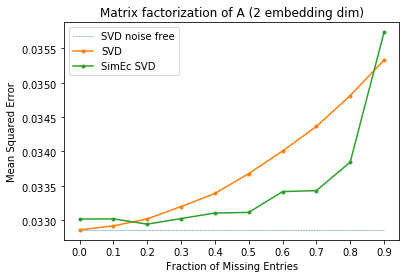

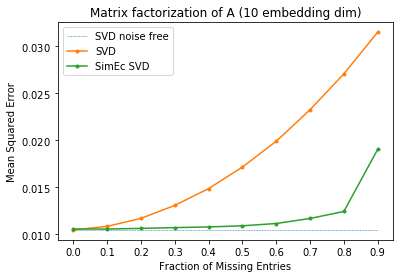

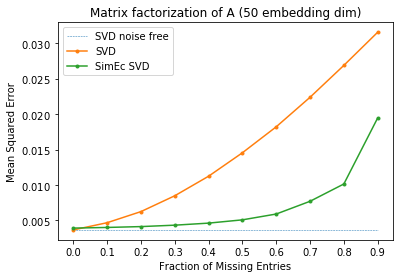

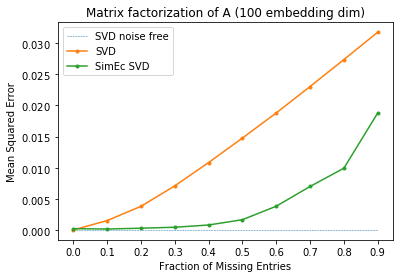

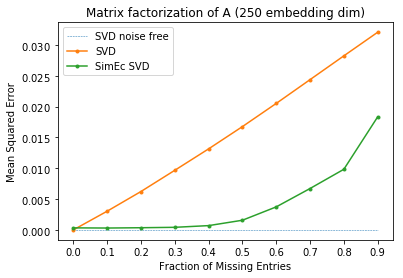

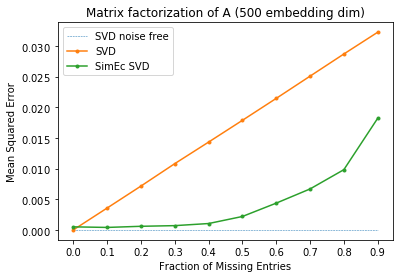

In [10]:
X = np.eye(n_input)
missing_targets = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
e_dims =  [2, 10, 50, 100, 250, 500]
for e_dim in e_dims:
    np.random.seed(15)
    mses = []
    mses_svd = []
    mse_svd = msqe(A, np.dot(U[:,:e_dim], np.dot(S[:e_dim,:e_dim], Vh[:e_dim,:])))
    for m in missing_targets:
        print m
        A_noisy = A.copy()
        A_noisy[np.random.rand(*A_noisy.shape)<=m] = -100
        model = SimilarityEncoder(n_input, e_dim, n_output, mask_value=-100, l2_reg_emb=0.00001, 
                                  l2_reg_out=0. if m < 0.7 else 0.00001, opt=keras.optimizers.Adamax(lr=0.025 if e_dim < 50 else 0.01))
        model.fit(X, A_noisy, epochs=60)
        mse = msqe(A, model.predict(X))
        mses.append(mse)
        A_noisy[A_noisy == -100] = np.mean(A)
        U_n, s_n, Vh_n = np.linalg.svd(A_noisy, full_matrices=True)
        S_n = np.zeros((n_input, n_output))
        S_n[:n_input, :n_input] = np.diag(s_n)
        mses_svd.append(msqe(A, np.dot(U_n[:,:e_dim], np.dot(S_n[:e_dim,:e_dim], Vh_n[:e_dim,:]))))
    print mses
    plt.figure();
    plt.plot([0, missing_targets[-1]], [mse_svd, mse_svd], '--', linewidth=0.5, label='SVD noise free');
    plt.plot(missing_targets, mses_svd, '-o', markersize=3, label='SVD');
    plt.plot(missing_targets, mses, '-o', markersize=3, label='SimEc SVD');
    plt.legend(loc=0);
    plt.title('Matrix factorization of A (%i embedding dim)' % e_dim);
    plt.xticks(missing_targets, missing_targets);
    plt.xlabel('Fraction of Missing Entries');
    plt.ylabel('Mean Squared Error');

### Eigendecomposition of a square symmetric matrix

In [11]:
# get 2 square symmetric matrices as AA^T and A^TA
S1 = np.dot(A, A.T)
S2 = np.dot(A.T, A)
# make sure their range of values is still sort of reasonable (for >100 we should probably rescale)
np.max(S1), np.min(S1), np.max(S2), np.min(S2)

(59.695435723025966,
 -27.98543792640249,
 41.138757582464692,
 -20.548242102046601)

In [12]:
# the corresponding SVD eigenvalues and -vectors should work here as well
for e_dim in [2, 10, 25, 50, 75, 100, 250, 400, 500]:
    print "mse with %3i e_dim: %11.8f" % (e_dim, msqe(S1, np.dot(U[:,:e_dim], np.dot(S[:e_dim,:e_dim]**2, U.T[:e_dim,:]))))
S_out = np.zeros((n_output, n_output))
S_out[:n_input, :n_input] = S[:n_input, :n_input]
for e_dim in [2, 10, 25, 50, 75, 100, 250, 500, 700]:
    print "mse with %3i e_dim: %11.8f" % (e_dim, msqe(S2, np.dot(Vh.T[:,:e_dim], np.dot(S_out[:e_dim,:e_dim]**2, Vh[:e_dim,:]))))

mse with   2 e_dim: 31.81649696
mse with  10 e_dim:  1.06578559
mse with  25 e_dim:  0.22234735
mse with  50 e_dim:  0.12643778
mse with  75 e_dim:  0.05437228
mse with 100 e_dim:  0.00001633
mse with 250 e_dim:  0.00000222
mse with 400 e_dim:  0.00000009
mse with 500 e_dim:  0.00000000
mse with   2 e_dim: 16.23290661
mse with  10 e_dim:  0.54376816
mse with  25 e_dim:  0.11344252
mse with  50 e_dim:  0.06450907
mse with  75 e_dim:  0.02774096
mse with 100 e_dim:  0.00000833
mse with 250 e_dim:  0.00000113
mse with 500 e_dim:  0.00000000
mse with 700 e_dim:  0.00000000


In [13]:
# factorize the similarity matrix S1 with a simec
X = np.eye(n_input)
mses1 = []
mses2 = []
e_dims =  [2,   10,  25,  50,  75,  100,  250,  400,  500,  750,  1000]
l_rates = [0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01]
for i, e_dim in enumerate(e_dims):
    model = SimilarityEncoder(n_input, e_dim, S1.shape[1], s_ll_reg=1., S_ll=S1, opt=keras.optimizers.Adamax(lr=l_rates[i]))
    model.fit(X, S1, epochs=100)
    mse = msqe(S1, model.predict(X))
    mses1.append(mse)
    print "mse with %4i e_dim: %11.8f" % (e_dim, mse)
    # scalar product of emedding should also approximate S1
    Y = model.transform(X)
    mse = msqe(S1, np.dot(Y, Y.T))
    mses2.append(mse)
    print "mse with %4i e_dim: %11.8f" % (e_dim, mse)
for i, e_dim in enumerate(e_dims):
    print "mse with %4i e_dim: %11.8f (%11.8f)" % (e_dim, mses1[i], mses2[i])

Epoch 1/100
500/500 [==============================] - 1s 3ms/step - loss: 10185.8741
Epoch 2/100
500/500 [==============================] - 0s 140us/step - loss: 8904.9244
Epoch 3/100
500/500 [==============================] - 0s 101us/step - loss: 8254.8403
Epoch 4/100
500/500 [==============================] - 0s 118us/step - loss: 8118.8107
Epoch 5/100
500/500 [==============================] - 0s 104us/step - loss: 8070.9904
Epoch 6/100
500/500 [==============================] - 0s 121us/step - loss: 8049.6295
Epoch 7/100
500/500 [==============================] - 0s 99us/step - loss: 8036.1117
Epoch 8/100
500/500 [==============================] - 0s 111us/step - loss: 8025.6761
Epoch 9/100
500/500 [==============================] - 0s 118us/step - loss: 8017.4541
Epoch 10/100
500/500 [==============================] - 0s 129us/step - loss: 8010.9893
Epoch 11/100
500/500 [==============================] - 0s 104us/step - loss: 8005.9100
Epoch 12/100
500/500 [=====================

500/500 [==============================] - 0s 102us/step - loss: 7985.9546
Epoch 95/100
500/500 [==============================] - 0s 124us/step - loss: 7985.9543
Epoch 96/100
500/500 [==============================] - 0s 89us/step - loss: 7985.9547
Epoch 97/100
500/500 [==============================] - 0s 107us/step - loss: 7985.9542
Epoch 98/100
500/500 [==============================] - 0s 93us/step - loss: 7985.9549
Epoch 99/100
500/500 [==============================] - 0s 122us/step - loss: 7985.9545
Epoch 100/100
500/500 [==============================] - 0s 98us/step - loss: 7985.9543
mse with    2 e_dim: 31.81653541
mse with    2 e_dim: 31.81660670
Epoch 1/100
500/500 [==============================] - 1s 3ms/step - loss: 9327.6062
Epoch 2/100
500/500 [==============================] - 0s 110us/step - loss: 4793.7420
Epoch 3/100
500/500 [==============================] - 0s 102us/step - loss: 1968.0226
Epoch 4/100
500/500 [==============================] - 0s 97us/step - loss

Epoch 88/100
500/500 [==============================] - 0s 94us/step - loss: 267.6031
Epoch 89/100
500/500 [==============================] - 0s 89us/step - loss: 267.6028
Epoch 90/100
500/500 [==============================] - 0s 90us/step - loss: 267.6026
Epoch 91/100
500/500 [==============================] - 0s 130us/step - loss: 267.6025
Epoch 92/100
500/500 [==============================] - 0s 124us/step - loss: 267.6023
Epoch 93/100
500/500 [==============================] - 0s 126us/step - loss: 267.6021
Epoch 94/100
500/500 [==============================] - 0s 104us/step - loss: 267.6020
Epoch 95/100
500/500 [==============================] - 0s 109us/step - loss: 267.6020
Epoch 96/100
500/500 [==============================] - 0s 103us/step - loss: 267.6019
Epoch 97/100
500/500 [==============================] - 0s 111us/step - loss: 267.6019
Epoch 98/100
500/500 [==============================] - 0s 105us/step - loss: 267.6018
Epoch 99/100
500/500 [========================

500/500 [==============================] - 0s 107us/step - loss: 56.1354
Epoch 83/100
500/500 [==============================] - 0s 120us/step - loss: 56.1302
Epoch 84/100
500/500 [==============================] - 0s 105us/step - loss: 56.1251
Epoch 85/100
500/500 [==============================] - 0s 106us/step - loss: 56.1202
Epoch 86/100
500/500 [==============================] - 0s 102us/step - loss: 56.1156
Epoch 87/100
500/500 [==============================] - 0s 114us/step - loss: 56.1111
Epoch 88/100
500/500 [==============================] - 0s 108us/step - loss: 56.1067
Epoch 89/100
500/500 [==============================] - 0s 93us/step - loss: 56.1024
Epoch 90/100
500/500 [==============================] - 0s 106us/step - loss: 56.0983
Epoch 91/100
500/500 [==============================] - 0s 104us/step - loss: 56.0944
Epoch 92/100
500/500 [==============================] - 0s 107us/step - loss: 56.0905
Epoch 93/100
500/500 [==============================] - 0s 112us/ste

500/500 [==============================] - 0s 105us/step - loss: 32.1276
Epoch 78/100
500/500 [==============================] - 0s 134us/step - loss: 32.1177
Epoch 79/100
500/500 [==============================] - 0s 115us/step - loss: 32.1082
Epoch 80/100
500/500 [==============================] - 0s 122us/step - loss: 32.0994
Epoch 81/100
500/500 [==============================] - 0s 111us/step - loss: 32.0904
Epoch 82/100
500/500 [==============================] - 0s 123us/step - loss: 32.0821
Epoch 83/100
500/500 [==============================] - 0s 124us/step - loss: 32.0743
Epoch 84/100
500/500 [==============================] - 0s 106us/step - loss: 32.0665
Epoch 85/100
500/500 [==============================] - 0s 129us/step - loss: 32.0592
Epoch 86/100
500/500 [==============================] - 0s 110us/step - loss: 32.0521
Epoch 87/100
500/500 [==============================] - 0s 82us/step - loss: 32.0451
Epoch 88/100
500/500 [==============================] - 0s 102us/ste

500/500 [==============================] - 0s 114us/step - loss: 14.0236
Epoch 72/100
500/500 [==============================] - 0s 120us/step - loss: 14.0136
Epoch 73/100
500/500 [==============================] - 0s 126us/step - loss: 14.0033
Epoch 74/100
500/500 [==============================] - 0s 104us/step - loss: 13.9938
Epoch 75/100
500/500 [==============================] - 0s 110us/step - loss: 13.9846
Epoch 76/100
500/500 [==============================] - 0s 110us/step - loss: 13.9762
Epoch 77/100
500/500 [==============================] - 0s 105us/step - loss: 13.9680
Epoch 78/100
500/500 [==============================] - 0s 111us/step - loss: 13.9598
Epoch 79/100
500/500 [==============================] - 0s 111us/step - loss: 13.9526
Epoch 80/100
500/500 [==============================] - 0s 124us/step - loss: 13.9455
Epoch 81/100
500/500 [==============================] - 0s 119us/step - loss: 13.9391
Epoch 82/100
500/500 [==============================] - 0s 108us/st

Epoch 66/100
500/500 [==============================] - 0s 96us/step - loss: 0.2786
Epoch 67/100
500/500 [==============================] - 0s 101us/step - loss: 0.2743
Epoch 68/100
500/500 [==============================] - 0s 100us/step - loss: 0.2701
Epoch 69/100
500/500 [==============================] - 0s 94us/step - loss: 0.2661
Epoch 70/100
500/500 [==============================] - 0s 91us/step - loss: 0.2622
Epoch 71/100
500/500 [==============================] - 0s 96us/step - loss: 0.2585
Epoch 72/100
500/500 [==============================] - 0s 98us/step - loss: 0.2548
Epoch 73/100
500/500 [==============================] - 0s 97us/step - loss: 0.2512
Epoch 74/100
500/500 [==============================] - 0s 99us/step - loss: 0.2477
Epoch 75/100
500/500 [==============================] - 0s 94us/step - loss: 0.2443
Epoch 76/100
500/500 [==============================] - 0s 109us/step - loss: 0.2410
Epoch 77/100
500/500 [==============================] - 0s 109us/step - l

Epoch 62/100
500/500 [==============================] - 0s 102us/step - loss: 0.2396
Epoch 63/100
500/500 [==============================] - 0s 106us/step - loss: 0.2352
Epoch 64/100
500/500 [==============================] - 0s 94us/step - loss: 0.2309
Epoch 65/100
500/500 [==============================] - 0s 113us/step - loss: 0.2269
Epoch 66/100
500/500 [==============================] - 0s 106us/step - loss: 0.2230
Epoch 67/100
500/500 [==============================] - 0s 109us/step - loss: 0.2193
Epoch 68/100
500/500 [==============================] - 0s 114us/step - loss: 0.2158
Epoch 69/100
500/500 [==============================] - 0s 114us/step - loss: 0.2124
Epoch 70/100
500/500 [==============================] - 0s 110us/step - loss: 0.2093
Epoch 71/100
500/500 [==============================] - 0s 94us/step - loss: 0.2062
Epoch 72/100
500/500 [==============================] - 0s 100us/step - loss: 0.2032
Epoch 73/100
500/500 [==============================] - 0s 114us/st

500/500 [==============================] - 0s 116us/step - loss: 1.4068
Epoch 58/100
500/500 [==============================] - 0s 111us/step - loss: 1.3442
Epoch 59/100
500/500 [==============================] - 0s 105us/step - loss: 1.2854
Epoch 60/100
500/500 [==============================] - 0s 102us/step - loss: 1.2305
Epoch 61/100
500/500 [==============================] - 0s 101us/step - loss: 1.1795
Epoch 62/100
500/500 [==============================] - 0s 110us/step - loss: 1.1316
Epoch 63/100
500/500 [==============================] - 0s 114us/step - loss: 1.0862
Epoch 64/100
500/500 [==============================] - 0s 126us/step - loss: 1.0443
Epoch 65/100
500/500 [==============================] - 0s 99us/step - loss: 1.0046
Epoch 66/100
500/500 [==============================] - 0s 107us/step - loss: 0.9674
Epoch 67/100
500/500 [==============================] - 0s 108us/step - loss: 0.9322
Epoch 68/100
500/500 [==============================] - 0s 104us/step - loss: 0

500/500 [==============================] - 0s 123us/step - loss: 1.5113
Epoch 53/100
500/500 [==============================] - 0s 127us/step - loss: 1.4420
Epoch 54/100
500/500 [==============================] - 0s 109us/step - loss: 1.3766
Epoch 55/100
500/500 [==============================] - 0s 103us/step - loss: 1.3148
Epoch 56/100
500/500 [==============================] - 0s 108us/step - loss: 1.2573
Epoch 57/100
500/500 [==============================] - 0s 136us/step - loss: 1.2038
Epoch 58/100
500/500 [==============================] - 0s 111us/step - loss: 1.1546
Epoch 59/100
500/500 [==============================] - 0s 107us/step - loss: 1.1075
Epoch 60/100
500/500 [==============================] - 0s 105us/step - loss: 1.0645
Epoch 61/100
500/500 [==============================] - 0s 126us/step - loss: 1.0234
Epoch 62/100
500/500 [==============================] - 0s 127us/step - loss: 0.9850
Epoch 63/100
500/500 [==============================] - 0s 131us/step - loss: 

500/500 [==============================] - 0s 131us/step - loss: 1.4678
Epoch 48/100
500/500 [==============================] - 0s 137us/step - loss: 1.3976
Epoch 49/100
500/500 [==============================] - ETA: 0s - loss: 1.332 - 0s 120us/step - loss: 1.3331
Epoch 50/100
500/500 [==============================] - 0s 135us/step - loss: 1.2730
Epoch 51/100
500/500 [==============================] - 0s 126us/step - loss: 1.2166
Epoch 52/100
500/500 [==============================] - 0s 123us/step - loss: 1.1645
Epoch 53/100
500/500 [==============================] - 0s 135us/step - loss: 1.1157
Epoch 54/100
500/500 [==============================] - 0s 120us/step - loss: 1.0701
Epoch 55/100
500/500 [==============================] - 0s 138us/step - loss: 1.0272
Epoch 56/100
500/500 [==============================] - 0s 125us/step - loss: 0.9875
Epoch 57/100
500/500 [==============================] - 0s 116us/step - loss: 0.9504
Epoch 58/100
500/500 [==============================] 

Epoch 42/100
500/500 [==============================] - 0s 145us/step - loss: 1.5651
Epoch 43/100
500/500 [==============================] - 0s 143us/step - loss: 1.4864
Epoch 44/100
500/500 [==============================] - 0s 142us/step - loss: 1.4138
Epoch 45/100
500/500 [==============================] - 0s 124us/step - loss: 1.3461
Epoch 46/100
500/500 [==============================] - 0s 139us/step - loss: 1.2835
Epoch 47/100
500/500 [==============================] - 0s 152us/step - loss: 1.2257
Epoch 48/100
500/500 [==============================] - 0s 145us/step - loss: 1.1722
Epoch 49/100
500/500 [==============================] - 0s 137us/step - loss: 1.1221
Epoch 50/100
500/500 [==============================] - 0s 144us/step - loss: 1.0752
Epoch 51/100
500/500 [==============================] - 0s 163us/step - loss: 1.0315
Epoch 52/100
500/500 [==============================] - 0s 147us/step - loss: 0.9904
Epoch 53/100
500/500 [==============================] - 0s 143us/

In [14]:
# factorize the similarity matrix S2 with a simec
X = np.eye(n_output)
mses1 = []
mses2 = []
e_dims =  [2,   10,  25,  50,  75,  100,  250,  400,  500,  750,  1000]
l_rates = [0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01]
for i, e_dim in enumerate(e_dims):
    model = SimilarityEncoder(n_output, e_dim, S2.shape[1], s_ll_reg=1., S_ll=S2, opt=keras.optimizers.Adamax(lr=l_rates[i]))
    model.fit(X, S2, epochs=60)
    mse = msqe(S2, model.predict(X))
    mses1.append(mse)
    print "mse with %4i e_dim: %11.8f" % (e_dim, mse)
    # scalar product of emedding should also approximate S1
    Y = model.transform(X)
    mse = msqe(S2, np.dot(Y, Y.T))
    mses2.append(mse)
    print "mse with %4i e_dim: %11.8f" % (e_dim, mse)
for i, e_dim in enumerate(e_dims):
    print "mse with %4i e_dim: %11.8f (%11.8f)" % (e_dim, mses1[i], mses2[i])

Epoch 1/60
700/700 [==============================] - 2s 2ms/step - loss: 7073.8368
Epoch 2/60
700/700 [==============================] - 0s 99us/step - loss: 6071.9724
Epoch 3/60
700/700 [==============================] - 0s 99us/step - loss: 5836.6517
Epoch 4/60
700/700 [==============================] - 0s 108us/step - loss: 5752.7944
Epoch 5/60
700/700 [==============================] - 0s 110us/step - loss: 5728.9919
Epoch 6/60
700/700 [==============================] - 0s 121us/step - loss: 5722.4817
Epoch 7/60
700/700 [==============================] - 0s 119us/step - loss: 5719.6689
Epoch 8/60
700/700 [==============================] - 0s 118us/step - loss: 5717.9235
Epoch 9/60
700/700 [==============================] - 0s 117us/step - loss: 5716.6512
Epoch 10/60
700/700 [==============================] - 0s 112us/step - loss: 5715.6388
Epoch 11/60
700/700 [==============================] - 0s 109us/step - loss: 5714.7499
Epoch 12/60
700/700 [==============================] - 0

700/700 [==============================] - 0s 100us/step - loss: 191.1077
Epoch 36/60
700/700 [==============================] - 0s 101us/step - loss: 191.0850
Epoch 37/60
700/700 [==============================] - 0s 103us/step - loss: 191.0664
Epoch 38/60
700/700 [==============================] - 0s 94us/step - loss: 191.0495
Epoch 39/60
700/700 [==============================] - 0s 105us/step - loss: 191.0348
Epoch 40/60
700/700 [==============================] - 0s 112us/step - loss: 191.0221
Epoch 41/60
700/700 [==============================] - 0s 108us/step - loss: 191.0118
Epoch 42/60
700/700 [==============================] - 0s 115us/step - loss: 191.0022
Epoch 43/60
700/700 [==============================] - 0s 110us/step - loss: 190.9949
Epoch 44/60
700/700 [==============================] - 0s 115us/step - loss: 190.9878
Epoch 45/60
700/700 [==============================] - 0s 121us/step - loss: 190.9821
Epoch 46/60
700/700 [==============================] - 0s 117us/ste

700/700 [==============================] - 0s 106us/step - loss: 32.3789
Epoch 10/60
700/700 [==============================] - 0s 107us/step - loss: 30.3544
Epoch 11/60
700/700 [==============================] - 0s 107us/step - loss: 28.8010
Epoch 12/60
700/700 [==============================] - 0s 131us/step - loss: 27.6637
Epoch 13/60
700/700 [==============================] - 0s 125us/step - loss: 26.8488
Epoch 14/60
700/700 [==============================] - 0s 121us/step - loss: 26.2715
Epoch 15/60
700/700 [==============================] - 0s 109us/step - loss: 25.8482
Epoch 16/60
700/700 [==============================] - 0s 102us/step - loss: 25.5250
Epoch 17/60
700/700 [==============================] - 0s 121us/step - loss: 25.2661
Epoch 18/60
700/700 [==============================] - 0s 107us/step - loss: 25.0489
Epoch 19/60
700/700 [==============================] - 0s 99us/step - loss: 24.8602
Epoch 20/60
700/700 [==============================] - 0s 109us/step - loss: 2

700/700 [==============================] - 0s 111us/step - loss: 10.1094
Epoch 45/60
700/700 [==============================] - 0s 115us/step - loss: 10.0947
Epoch 46/60
700/700 [==============================] - 0s 111us/step - loss: 10.0804
Epoch 47/60
700/700 [==============================] - 0s 122us/step - loss: 10.0675
Epoch 48/60
700/700 [==============================] - 0s 119us/step - loss: 10.0552
Epoch 49/60
700/700 [==============================] - 0s 117us/step - loss: 10.0443
Epoch 50/60
700/700 [==============================] - 0s 117us/step - loss: 10.0337
Epoch 51/60
700/700 [==============================] - 0s 121us/step - loss: 10.0245
Epoch 52/60
700/700 [==============================] - 0s 111us/step - loss: 10.0155
Epoch 53/60
700/700 [==============================] - 0s 116us/step - loss: 10.0073
Epoch 54/60
700/700 [==============================] - 0s 111us/step - loss: 10.0002
Epoch 55/60
700/700 [==============================] - 0s 116us/step - loss: 

700/700 [==============================] - 0s 106us/step - loss: 0.6133
Epoch 20/60
700/700 [==============================] - 0s 109us/step - loss: 0.5625
Epoch 21/60
700/700 [==============================] - 0s 107us/step - loss: 0.5201
Epoch 22/60
700/700 [==============================] - 0s 112us/step - loss: 0.4837
Epoch 23/60
700/700 [==============================] - 0s 120us/step - loss: 0.4525
Epoch 24/60
700/700 [==============================] - 0s 118us/step - loss: 0.4250
Epoch 25/60
700/700 [==============================] - 0s 105us/step - loss: 0.4008
Epoch 26/60
700/700 [==============================] - 0s 110us/step - loss: 0.3795
Epoch 27/60
700/700 [==============================] - 0s 113us/step - loss: 0.3606
Epoch 28/60
700/700 [==============================] - 0s 106us/step - loss: 0.3436
Epoch 29/60
700/700 [==============================] - 0s 107us/step - loss: 0.3283
Epoch 30/60
700/700 [==============================] - 0s 107us/step - loss: 0.3144
Epoc

700/700 [==============================] - 0s 142us/step - loss: 0.4946
Epoch 56/60
700/700 [==============================] - 0s 138us/step - loss: 0.4767
Epoch 57/60
700/700 [==============================] - 0s 135us/step - loss: 0.4602
Epoch 58/60
700/700 [==============================] - 0s 133us/step - loss: 0.4445
Epoch 59/60
700/700 [==============================] - 0s 134us/step - loss: 0.4299
Epoch 60/60
700/700 [==============================] - 0s 125us/step - loss: 0.4161
mse with  400 e_dim:  0.08136889
mse with  400 e_dim:  0.19683863
Epoch 1/60
700/700 [==============================] - 2s 3ms/step - loss: 5669.9646
Epoch 2/60
700/700 [==============================] - 0s 133us/step - loss: 841.2190
Epoch 3/60
700/700 [==============================] - 0s 147us/step - loss: 195.3990
Epoch 4/60
700/700 [==============================] - 0s 134us/step - loss: 95.0729
Epoch 5/60
700/700 [==============================] - 0s 137us/step - loss: 57.2649
Epoch 6/60
700/700 [

700/700 [==============================] - 0s 152us/step - loss: 1.4064
Epoch 31/60
700/700 [==============================] - 0s 160us/step - loss: 1.3041
Epoch 32/60
700/700 [==============================] - 0s 152us/step - loss: 1.2138
Epoch 33/60
700/700 [==============================] - 0s 153us/step - loss: 1.1332
Epoch 34/60
700/700 [==============================] - 0s 158us/step - loss: 1.0603
Epoch 35/60
700/700 [==============================] - 0s 151us/step - loss: 0.9951
Epoch 36/60
700/700 [==============================] - 0s 155us/step - loss: 0.9365
Epoch 37/60
700/700 [==============================] - 0s 148us/step - loss: 0.8834
Epoch 38/60
700/700 [==============================] - 0s 148us/step - loss: 0.8354
Epoch 39/60
700/700 [==============================] - 0s 150us/step - loss: 0.7914
Epoch 40/60
700/700 [==============================] - 0s 155us/step - loss: 0.7516
Epoch 41/60
700/700 [==============================] - 0s 144us/step - loss: 0.7149
Epoc